In [1]:
from fastai2.vision.all import load_learner, get_image_files
import torch
from pathlib import Path
import json, os, sys
import pandas as pd
sys.path.append('..')
from modules.trainutils import piece_class_parse
from modules.trainutils import my_metrics

In [22]:
config_dir = Path('../dbin/')
fns = os.listdir(config_dir)

In [23]:
i = 3

base_name = f"basicexp-{i}"

df_valid = pd.read_csv(config_dir / (base_name + "_valid.csv"))                       
df_test  = pd.read_csv(config_dir / (base_name + "_test.csv"))
df_resid  = pd.read_csv(config_dir / (base_name + "_residuals.csv"))

with open(config_dir / (base_name + "_params.json")) as f:
    d_params = json.load(f)

### Explore the tables

In [43]:
df_params = pd.DataFrame(d_params, index=[base_name]).T
df_params

,basicexp-3
_train_name,rf-v1-crops
_test_name,test-regulation-2-all
_train_path,../../../rf-chess-data/cropped_v1
_test_path,../../../other-chess-data/regulation-test-2-all
_model_arch,resnet50
_fit_one_cycle_epochs,10
_fine_tune_epochs,15
_train_seed,1
_valid_pct,0.2
_mult,1


In [46]:
df_valid.head()

,train_loss,valid_loss,accuracy,subcat_color_acc,subcat_piece_acc
0,1.051908,0.124853,0.979094,0.994774,0.986063
1,0.380139,0.102692,0.987805,0.994774,0.993031
2,0.214870,0.143364,0.979094,0.994774,0.984321
3,0.152900,0.104348,0.991289,0.996516,0.994774
4,0.113418,0.123801,0.989547,0.993031,0.996516


In [45]:
df_test.head()

,test_loss,test_accuracy,test_subcat_color_acc,test_subcat_piece_acc
0,2.369782,0.372807,0.754386,0.464912
1,2.346915,0.394737,0.754386,0.526316
2,2.674466,0.372807,0.815789,0.469298
3,2.498808,0.372807,0.802632,0.438596
4,2.621854,0.403509,0.793860,0.521930


In [47]:
df_resid

,Unnamed: 0,fn,label,actual,pred,loss
0,0,02c00099_white-pawn.jpg,white-pawn,9,9,0.000545
1,1,01c00030_white-rook.jpg,white-rook,11,11,0.974077
2,2,02c00126_white-knight.jpg,white-knight,8,8,0.684474
3,3,01c00041_black-bishop.jpg,black-bishop,0,2,5.144682
4,4,02c00027_white-pawn.jpg,white-pawn,9,9,-0.000000
...,...,...,...,...,...,...
223,223,02c00017_black-queen.jpg,black-queen,4,4,0.002094
224,224,01c00010_black-queen.jpg,black-queen,4,2,3.540473
225,225,02c00090_white-knight.jpg,white-knight,8,8,0.014236
226,226,01c00000_white-king.jpg,white-king,7,7,0.000140


### MultiTable

In [91]:
config_dir = Path('../dbin/')
fns = os.listdir(config_dir)

In [92]:
name = 'basicexp'
fns = [fn for fn in fns if name in fn ]
nums = [e.split('-')[1].split('_')[0] for e in fns]
nums = list(set([int(e) for e in nums]))
nums

[0, 1, 2, 3, 4, 5, 6, 7]

In [205]:
df_metrics = pd.DataFrame()
df_resid = pd.DataFrame()
df_params = pd.DataFrame()

for i in nums:

    ## read in all four tables ------
    
    base_name = f"basicexp-{i}"

    _df_valid = pd.read_csv(config_dir / (base_name + "_valid.csv"))                       
    _df_test  = pd.read_csv(config_dir / (base_name + "_test.csv"))
    
    _df_resid  = pd.read_csv(config_dir / (base_name + "_residuals.csv"))

    with open(config_dir / (base_name + "_params.json")) as f:
        _d_params = json.load(f)
        
    ## concat + format df_valid, df_test -----
    _df_metrics = pd.concat((_df_valid, _df_test), axis=1)
    
    _df_metrics['epoch'] = _df_test.index
    _df_metrics['exp_name'] = base_name
    
    cols =  _df_metrics.columns[-2:].tolist()
    cols += _df_metrics.columns[:-2].tolist()
    
    _df_metrics = _df_metrics[cols]
    
    ## format df_resid ---------
    _df_resid.drop(columns=['Unnamed: 0'], inplace=True)
    
    _df_resid['correct'] = _df_resid['actual'] == _df_resid['label']
    _df_resid = _df_resid.rename(columns={
                        'pred': base_name + '_pred',
                        'loss': base_name + '_loss',
                        'correct': base_name + '_correct'})
    
    ## format df_params other tables
    _df_params = pd.DataFrame(_d_params, index=[base_name]).T
    
    
    ## concat to total tables ---------
    df_metrics = pd.concat((df_metrics, _df_metrics), axis=0)
    
    if 'label' not in df_resid.columns:
        df_resid = _df_resid.copy()
    else:
        cols = _df_resid.columns.difference(df_resid.columns).tolist()
        cols += ['fn']
        df_resid = pd.merge(df_resid, _df_resid[cols], 
                            how='outer', on='fn')
        
    df_params = pd.concat((df_params,_df_params ), axis=1)
    

In [206]:
df_params

,basicexp-0,basicexp-1,basicexp-2,basicexp-3,basicexp-4,basicexp-5,basicexp-6,basicexp-7
_train_name,rf-v1-crops,rf-v1-crops,rf-v1-crops,rf-v1-crops,rf-v1-crops,rf-v1-crops,rf-v1-crops,rf-v1-crops
_test_name,test-regulation-2-all,test-regulation-2-all,test-regulation-2-all,test-regulation-2-all,test-regulation-2-all,test-regulation-2-all,test-regulation-2-all,test-regulation-2-all
_train_path,../../../rf-chess-data/cropped_v1,../../../rf-chess-data/cropped_v1,../../../rf-chess-data/cropped_v1,../../../rf-chess-data/cropped_v1,../../../rf-chess-data/cropped_v1,../../../rf-chess-data/cropped_v1,../../../rf-chess-data/cropped_v1,../../../rf-chess-data/cropped_v1
_test_path,../../../other-chess-data/regulation-test-all-2,../../../other-chess-data/regulation-test-all-2,../../../other-chess-data/regulation-test-2-all,../../../other-chess-data/regulation-test-2-all,../../../other-chess-data/regulation-test-2-all,../../../other-chess-data/regulation-test-2-all,../../../other-chess-data/regulation-test-2-all,../../../other-chess-data/regulation-test-2-all
_model_arch,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50,resnet50
_fit_one_cycle_epochs,10,10,10,10,10,10,10,10
_fine_tune_epochs,15,15,15,15,15,15,15,15
_train_seed,99,22,0,1,2,0,1,2
_valid_pct,0.2,0.2,0.2,0.2,0.2,0.2,0.2,0.2
_mult,1,1,1,1,1,1,1,1


In [204]:
with open(config_dir / (base_name + "_params.json")) as f:
    d_params = json.load(f)
d = pd.DataFrame(d_params, index=[base_name]).T
d

,basicexp-7
_train_name,rf-v1-crops
_test_name,test-regulation-2-all
_train_path,../../../rf-chess-data/cropped_v1
_test_path,../../../other-chess-data/regulation-test-2-all
_model_arch,resnet50
_fit_one_cycle_epochs,10
_fine_tune_epochs,15
_train_seed,2
_valid_pct,0.2
_mult,1


In [201]:
from matplotlib import pyplot as plt

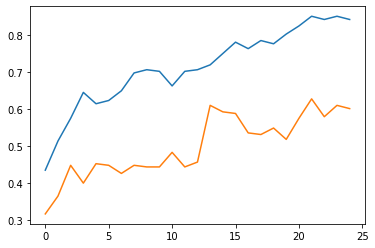

In [203]:
plt.plot(df_metrics[df_metrics['exp_name']=='basicexp-0']['test_accuracy'])
plt.plot(df_metrics[df_metrics['exp_name']=='basicexp-4']['test_accuracy'])